Initial x0: tensor([1.8570, 0.0000, 1.8570])
tensor(0.0700)
tensor(0.0697)
tensor(0.0695)
tensor(0.0693)
tensor(0.0691)
tensor(0.0689)
tensor(0.0687)
tensor(0.0685)
tensor(0.0683)
tensor(0.0681)
tensor(0.0679)
tensor(0.0678)
tensor(0.0676)
tensor(0.0674)
tensor(0.0673)
tensor(0.0671)
tensor(0.0669)
tensor(0.0668)
tensor(0.0666)
tensor(0.0665)
tensor(0.0663)
tensor(0.0662)
tensor(0.0661)
tensor(0.0659)
tensor(0.0658)
tensor(0.0657)
tensor(0.0655)
tensor(0.0654)
tensor(0.0653)
tensor(0.0651)
tensor(0.0650)
tensor(0.0649)
tensor(0.0648)
tensor(0.0647)
tensor(0.0646)
tensor(0.0645)
tensor(0.0644)
tensor(0.0643)
tensor(0.0641)
tensor(0.0640)
tensor(0.0640)
tensor(0.0639)
tensor(0.0638)
tensor(0.0637)
tensor(0.0636)
tensor(0.0635)
tensor(0.0634)
tensor(0.0633)
tensor(0.0632)
tensor(0.0631)
tensor(0.0631)
tensor(0.0630)
tensor(0.0629)
tensor(0.0628)
tensor(0.0627)
tensor(0.0627)
tensor(0.0626)
tensor(0.0625)
tensor(0.0625)
tensor(0.0624)
tensor(0.0623)
tensor(0.0623)
tensor(0.0622)
tensor(0.0

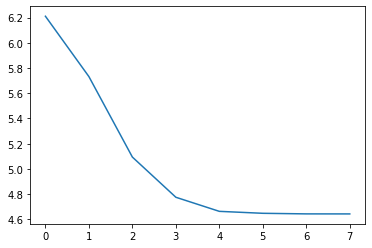

In [4]:
from sympy.solvers import solve
from sympy import Symbol
import torch as t
import math
import numpy as np
import matplotlib.pyplot as plt


# initial guess:
x1 = Symbol('x1')
x2 = 0
x1 = solve(x1**2/4 + x2**2/5 + (x1+x2)**2/25 - 1, x1)[1]
x3 = x1+x2
x = t.tensor([10*math.sqrt(29)/29, 0, 10*math.sqrt(29)/29])
print('Initial x0:',x)

# define problem:
def obj(x):
    return x[0]**2+x[1]**2+x[2]**2

def h(x):
    return t.tensor([[x[0]**2/4+x[1]**2/5+x[2]**2/25-1],
                    [x[0]+x[1]-x[2]]])

# define d and s, Choice d = x1 (x[0]); s = [x2 x3] (x[1], x[2])
def d(x):
    return t.tensor([x[0]])
def s(x):
    return t.tensor([x[1],x[2]])


# Calculate Gradient: e means partial derivative symbol
def ef_ed(x):
    return t.tensor([2*x[0]])

def ef_es(x):
    return t.tensor([2*x[1],2*x[2]])

def eh_es(x):
    return t.tensor([[2*x[1]/5,2*x[2]/25],
                    [1,-1]])

def eh_ed(x):
    return t.tensor([[x[0]/2],
                     [1]])

def df_dd(x):
    return ef_ed(x) - t.matmul(t.matmul(ef_es(x),t.inverse(eh_es(x))),eh_ed(x))

def linesearch(x):
    a = 1
    b = 0.5
    c = 0.3
    i = 0
    def f_a(x):
        x_k_1 = t.cat([d(x)-a*df_dd(x), t.squeeze(s(x) + a*t.transpose(t.matmul(t.inverse(eh_es(x)),eh_ed(x))*df_dd(x),0,1))])
        return obj(x_k_1)
    def f__a(x):
        return obj(x) - a*c*df_dd(x)**2
    while(f_a(x)>f__a(x)):
        a = b*a
        i = i+1
        if i>=50:
            print('linesearch issue')
            exit()
    return a

def solver(x):
    j = 0
    while t.norm(h(x))>0.06:
        Ch = t.matmul(t.inverse(t.add(t.matmul(eh_es(x),t.transpose(eh_es(x),0,1)),t.eye(2))),t.transpose(eh_es(x),0,1))
        s_k_1 = t.squeeze(s(x) - t.transpose(t.matmul(Ch,h(x)),0,1))
        x = t.cat([d_k_1, s_k_1])
        print(t.norm(h(x)))
        j = j+1
    return x

E = 0.01
F = []
k = 0
while df_dd(x)**2>E:
    a = linesearch(x)
    d_k_1 = d(x) - a*df_dd(x)
    s0_k_1 = t.squeeze(s(x) + a*t.transpose(t.matmul(t.inverse(eh_es(x)),eh_ed(x))*df_dd(x),0,1))
    x = t.cat([d_k_1, s0_k_1])
    x = solver(x)
    F = np.append(F,obj(x).numpy())
    k=k+1
K = np.arange(k)
plt.plot(K, F)
print('x = ',x.numpy())
print('Error of constraints, dh =',h(x).numpy())
print('min f =',obj(x).numpy())


In [1]:
# Verify
from scipy.optimize import minimize
fun = lambda x: x[0]**2 + x[1]**2+x[2]**2

cons = ({'type': 'eq', 'fun': lambda x:  x[0]**2/4+x[1]**2/5+x[2]**2/25-1},
        {'type': 'eq', 'fun': lambda x:  x[0]+x[1]-x[2]})
bnds = ((-2, 2), (-2.3, 2.3), (-5, 5))

x0 = [1,0,0]
res = minimize(fun, x0, method='SLSQP',bounds=bnds,
               constraints=cons)
res

     fun: 4.411764720309136
     jac: array([ 3.14753878, -2.75414187,  0.39339691])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([ 1.57376938, -1.37707095,  0.19669843])